In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import join_data as jd

In [4]:
from helpers import *

In [5]:
filesavelabel = 'publicdatacategory_'
predicted_delays_filename = './data_est_report_delays/category_borough_interaction_model_delays.csv'

# filesavelabel = 'publicdatarisk_'
# predicted_delays_filename = './data_est_report_delays/risk_borough_interaction_model_delays.csv'

# Load and join the public data

In [6]:
mergeddfpublic = jd.pipeline(directory = '../data/', FSfilename = 'FSR_221022.csv', FIfilename = 'FI_221022.csv', FWOfilename = 'FWO_221022.csv', FRAfilename = 'FRA_221024.csv')

In [7]:
mergeddfpublic.columns

Index(['OBJECTID', 'SRCategory', 'SRType', 'SRPriority', 'SRSource',
       'SRStatus', 'SRResolution', 'Borough', 'CommunityBoard',
       'ServiceRequestParentGlobalID', 'GlobalID', 'InitiatedDate',
       'SRClosedDate', 'SRCreatedDate', 'SRUpdatedDate', 'Descriptor1',
       'ComplaintType', 'CallerZipCode', 'SRCallerType', 'Latitude',
       'Longitude', 'Census Tract', 'NTA', 'SRGlobalID', 'InspectionType',
       'InspectionStatus', 'InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH', 'InsGlobalID', 'InspectionDate', 'InsClosedDate',
       'InsCreatedDate', 'InsUpdatedDate', 'ParentInspectionGlobalID',
       'ReinspectionDate', 'Location', 'WOType', 'WOStatus', 'WOPriority',
       'ActualFinishDate', 'CancelReason', 'WOCategory', 'WOGlobalID',
       'WOClosedDate', 'CancelDate', 'WOCreatedDate', 'WOUpdatedDate',
       'WOEntity', 'PROJSTARTDATE', 'WOProject', 'RecommendedSpecies',
       'Location_WO', 'RADefect', 'RADefectLocation', 'Failure',
       'I

### Load + join model estimates for reporting delays

We have a dataframe where we have predicted report delays for many incidents (that were used to train the model). We also want to have predicted reporting delays for other incidents. So what we will do is extract coefficients from that dataframe (we can do this perfectly except for Bayesian noise) and apply the model to all the incidents.

In [8]:
predicted_report_delays = pd.read_csv(predicted_delays_filename)
predicted_report_delays = predicted_report_delays.rename(columns = {'SRID': 'OBJECTID', 'delay': 'reporting_delay'})

In [9]:
predicted_report_delays.head()

,Unnamed: 0,OBJECTID,Borough,CommunityBoard,Category,type,SRCreatedDate,SRClosedDate,death_time,TruncDuration,Duration,reporting_delay
0,0,17944200,Brooklyn,318.0,Hazard,Limb Down - Sidewalk,2020-06-30 03:03:00,2020-07-08 00:40:00,2020-06-30 15:20:00,0.511806,0.511806,11.0702
1,1,12185633,Staten Island,502.0,Remove Tree,Dead Tree Older Than 2 Years,2018-08-15 23:42:00,2019-04-02 02:24:43,2018-08-21 11:33:50,5.494329,5.494329,16.7812
2,2,13020663,Queens,408.0,Remove Tree,Poor Condition Cracked,2018-11-01 15:45:00,2018-11-05 10:58:19,2018-11-05 10:57:52,3.800602,3.800602,49.7934
3,3,12105835,Queens,410.0,Hazard,Limb Down - Other,2018-07-28 01:51:00,2018-08-01 18:21:00,2018-07-28 09:44:42,0.328958,0.328958,6.2046
4,5,15854795,Queens,407.0,Hazard,Limb Down - Sidewalk,2019-08-12 23:30:00,2019-08-16 15:14:35,2019-08-16 15:16:45,3.657465,3.657465,9.6748


In [10]:
predicted_report_delays_joinedwithfeatures = pd.merge(predicted_report_delays, mergeddfpublic, on='OBJECTID', how='left', suffixes=('', '_public')).drop_duplicates(subset = 'OBJECTID')

In [11]:
predicted_report_delays.count()

Unnamed: 0         77430
OBJECTID           77430
Borough            77430
CommunityBoard     77430
Category           77430
type               77430
SRCreatedDate      77430
SRClosedDate       75641
death_time         77430
TruncDuration      77430
Duration           77430
reporting_delay    77430
dtype: int64

In [12]:
predicted_report_delays_joinedwithfeatures.count()

Unnamed: 0             77430
OBJECTID               77430
Borough                77430
CommunityBoard         77430
Category               77430
                       ...  
WorkOrderGlobalID      20375
IncidentGlobalID       77430
inspection_attached    77430
wo_attached            77430
Risk_coded             77430
Length: 78, dtype: int64

In [13]:
#statsmodels from formula import
import statsmodels.formula.api as smf

In [14]:
predicted_report_delays_joinedwithfeatures.columns

Index(['Unnamed: 0', 'OBJECTID', 'Borough', 'CommunityBoard', 'Category',
       'type', 'SRCreatedDate', 'SRClosedDate', 'death_time', 'TruncDuration',
       'Duration', 'reporting_delay', 'SRCategory', 'SRType', 'SRPriority',
       'SRSource', 'SRStatus', 'SRResolution', 'Borough_public',
       'CommunityBoard_public', 'ServiceRequestParentGlobalID', 'GlobalID',
       'InitiatedDate', 'SRClosedDate_public', 'SRCreatedDate_public',
       'SRUpdatedDate', 'Descriptor1', 'ComplaintType', 'CallerZipCode',
       'SRCallerType', 'Latitude', 'Longitude', 'Census Tract', 'NTA',
       'SRGlobalID', 'InspectionType', 'InspectionStatus',
       'InspectionTPCondition', 'InspectionTPStructure', 'TreePointDBH',
       'InsGlobalID', 'InspectionDate', 'InsClosedDate', 'InsCreatedDate',
       'InsUpdatedDate', 'ParentInspectionGlobalID', 'ReinspectionDate',
       'Location', 'WOType', 'WOStatus', 'WOPriority', 'ActualFinishDate',
       'CancelReason', 'WOCategory', 'WOGlobalID', 'WOClosed

In [15]:
cols = ['SRCategory', 'Borough', 'RiskRating', 'InspectionTPCondition', 'TreePointDBH']

predicted_report_delays_joinedwithfeatures.loc[:, 'reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('1/reporting_delay')

predicted_report_delays_joinedwithfeatures.loc[:, 'log_reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('log(1/reporting_delay)')


#regress reporting delay on category, borough, and risk
model = smf.ols(formula='log_reporting_rate ~ 1 + C(SRCategory) + C(Borough) + C(Risk_coded) + C(Borough):C(SRCategory) + InspectionTPCondition + np.log(TreePointDBH + 1)', data=predicted_report_delays_joinedwithfeatures).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_reporting_rate   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 1.177e+05
Date:                Fri, 16 Jun 2023   Prob (F-statistic):               0.00
Time:                        12:48:16   Log-Likelihood:                 29375.
No. Observations:               76712   AIC:                        -5.868e+04
Df Residuals:                   76675   BIC:                        -5.833e+04
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
====================================================================================================================================
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                           -1.2007      0.007   -166.651      0.000      -1.215      -1.187
C(SRCategory)[T.Illegal Tree Damage]                                -1.3599      0.009   -151.231      0.000      -1.378      -1.342
C(SRCategory)[T.Prune]                                              -2.0160      0.005   -419.405      0.000      -2.025      -2.007
C(SRCategory)[T.Remove Tree]                                        -1.7668      0.005   -331.225      0.000      -1.777      -1.756
C(SRCategory)[T.Root/Sewer/Sidewalk]                                -3.2417      0.006   -582.469      0.000      -3.253      -3.231
C(Borough)[T.Brooklyn]                                              -0.5498      0.004   -142.051      0.000      -0.557      -0.542
C(Borough)[T.Manhattan]                                              0.7493      0.006    130.676      0.000       0.738       0.761
C(Borough)[T.Queens]                                                -0.3997      0.004   -105.467      0.000      -0.407      -0.392
C(Borough)[T.Staten Island]                                          0.0379      0.005      7.487      0.000       0.028       0.048
C(Risk_coded)[T.B]                                                  -0.1585      0.005    -33.580      0.000      -0.168      -0.149
C(Risk_coded)[T.C]                                                  -0.2620      0.004    -60.281      0.000      -0.271      -0.254
C(Risk_coded)[T.D]                                                  -0.5265      0.004   -130.303      0.000      -0.534      -0.519
C(Risk_coded)[T.E]                                                  -0.8562      0.028    -30.321      0.000      -0.912      -0.801
C(Risk_coded)[T.Unknown]                                            -0.4436      0.015    -29.574      0.000      -0.473      -0.414
InspectionTPCondition[T.Dead]                                       -0.3011      0.006    -53.954      0.000      -0.312      -0.290
InspectionTPCondition[T.Excellent]                                  -0.4538      0.008    -54.520      0.000      -0.470      -0.438
InspectionTPCondition[T.Fair]                                       -0.1678      0.005    -31.096      0.000      -0.178      -0.157
InspectionTPCondition[T.Good]                                       -0.3939      0.005    -73.879      0.000      -0.404      -0.383
InspectionTPCondition[T.Poor]                                        0.0094      0.005      1.731      0.083      -0.001       0.020
InspectionTPCondition[T.Unknown]                                    -0.1270      0.096     -1.325      0.185      -0.315       0.061
C(Borough)[T.Brooklyn]:C

In [16]:
#now apply the model to nodups_rightdate
predicted_report_delays_joinedwithfeatures['log_reporting_rate_predicted'] = model.predict(predicted_report_delays_joinedwithfeatures)
predicted_report_delays_joinedwithfeatures['reporting_delay_predicted'] = predicted_report_delays_joinedwithfeatures.eval('1/exp(log_reporting_rate_predicted)')

(0.0, 100.0)

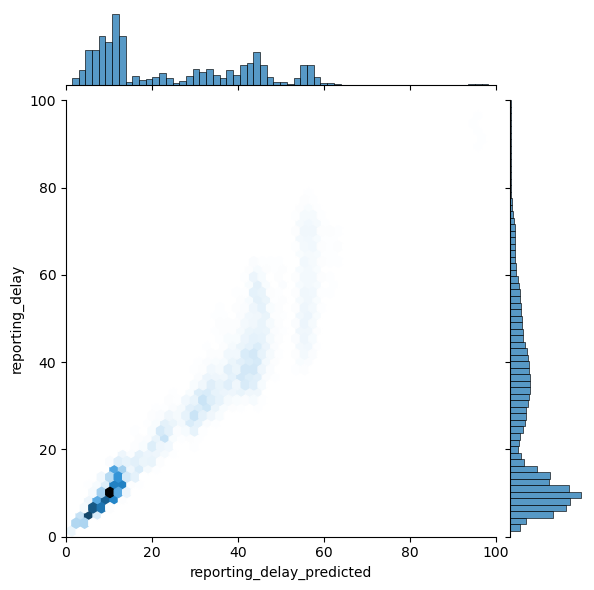

In [17]:
sns.jointplot(x='reporting_delay_predicted', y='reporting_delay', data=predicted_report_delays_joinedwithfeatures.query('reporting_delay_predicted < 100 and reporting_delay < 100'), kind='hex')
plt.xlim((0, 100))
plt.ylim((0, 100))

Ok, we have a good model of reporting delays, we can apply it to all the public data now

# Delay analysis final data preparation

First, combine multiple reports of the same incident so that I have one row per unique incident. Take first inspection and report date as the right date.

In [18]:
wofinishdatecolumn = 'ActualFinishDate' # 'WOClosedDate'

In [19]:
nodups = mergeddfpublic[['IncidentGlobalID','SRCategory','SRCreatedDate', 'InspectionDate',wofinishdatecolumn,'Risk_coded','RiskRating','Borough','InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH']].groupby('IncidentGlobalID').agg(
    {'SRCreatedDate': 'min', 'InspectionDate': 'min', wofinishdatecolumn: 'min', 'SRCategory': 'first', 'Risk_coded': 'first', 'Borough': 'first', 'RiskRating': 'first', 'InspectionTPCondition': 'first', 'InspectionTPStructure': 'first',
       'TreePointDBH': 'first'}).reset_index()
nodups['inspection_delay'] = (nodups['InspectionDate'] - nodups['SRCreatedDate']).dt.total_seconds() / 3600 /24
nodups['work_delay'] = (nodups[wofinishdatecolumn] - nodups['InspectionDate']).dt.total_seconds() / 3600 /24
nodups[['SRCreatedDate','InspectionDate', wofinishdatecolumn]].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,ActualFinishDate
count,552181,281992,129293
mean,2018-12-24 03:10:25.272691968,2019-01-24 20:10:01.489754624,2019-01-09 08:50:38.145823744
min,2015-02-28 14:03:49,1900-01-01 00:00:00,2014-11-01 04:00:00
25%,2017-04-07 19:40:00,2017-06-21 10:01:09.500000,2017-04-14 04:00:00
50%,2018-11-18 22:47:00,2018-12-21 09:41:59.500000,2019-01-19 05:00:00
75%,2020-08-18 21:17:00,2020-08-28 16:13:42.500000,2020-08-16 04:00:00
max,2022-09-01 02:05:31,2022-08-31 20:44:30,2022-08-31 04:00:00


In [20]:
nodups_rightdate = nodups[(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')]

In [21]:
nodups_rightdate = nodups_rightdate[nodups_rightdate.SRCategory.isin(predicted_report_delays_joinedwithfeatures.SRCategory.unique())]

In [22]:
nodups_rightdate[['SRCreatedDate','InspectionDate', 'work_delay']].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,work_delay
count,169881,109205,47045.000000
mean,2018-12-01 08:13:19.511175424,2019-01-01 16:15:30.679007488,132.252356
min,2017-06-30 00:02:43,1900-01-01 00:00:00,-1457.377627
25%,2018-03-30 13:34:00,2018-04-16 04:00:00,2.000000
50%,2018-10-26 13:30:25,2018-11-16 14:46:45,26.794456
75%,2019-08-09 16:51:00,2019-09-11 08:48:06,167.819931
max,2020-06-30 23:46:32,2022-08-25 16:04:55,1857.000000
std,NaN,NaN,238.733926


In [23]:
nodups_rightdate.loc[:,'log_reporting_rate'] = model.predict(nodups_rightdate)
nodups_rightdate.loc[:,'reporting_delay'] = nodups_rightdate.eval('1/exp(log_reporting_rate)')

In [24]:
nodups_rightdate.count()

IncidentGlobalID         169881
SRCreatedDate            169881
InspectionDate           109205
ActualFinishDate          47047
SRCategory               169881
Risk_coded               169881
Borough                  169848
RiskRating               102559
InspectionTPCondition    108468
InspectionTPStructure    108466
TreePointDBH             106905
inspection_delay         109205
work_delay                47045
log_reporting_rate       106903
reporting_delay          106903
dtype: int64

In [25]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()

/tmp/ipykernel_7641/2028202929.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()


reporting_delay  inspection_delay  \
SRCategory          Borough                                            
Hazard              Bronx                 6.086131          1.963947   
                    Brooklyn             10.632639          3.959722   
                    Manhattan             2.791090          0.485382   
                    Queens                9.076754          1.853906   
                    Staten Island         5.754143          1.502153   
Illegal Tree Damage Bronx                28.537608          8.880150   
                    Brooklyn             53.424254         37.128084   
                    Manhattan            15.074895          4.347917   
                    Queens               39.407184         25.789086   
                    Staten Island         8.630031          3.852153   
Prune               Bronx                56.604692         13.216713   
                    Brooklyn             35.696163         10.871279   
                    Manhattan            94.670902          5.618750   
                    Queens               54.368616          8.888241   
                    Staten Island        16.880382          3.250000   
Remove Tree         Bronx                37.516568          6.816672   
                    Brooklyn             38.869893         13.959201   
                    Manhattan            56.641090          3.440972   
                    Queens               35.778590          6.906262   
                    Staten Island        19.336108          4.486366   
Root/Sewer/Sidewalk Bronx               193.155248         18.884167   
                    Brooklyn            228.910582         20.887147   
                    Manhattan           338.971440         15.874965   
                    Queens              270.003432         18.859514   
                    Staten Island       243.269071         20.829329   

                                   work_delay  
SRCategory          Borough                    
Hazard              Bronx            6.803200  
                    Brooklyn        11.746597  
                    Manhattan        0.416661  
                    Queens           4.693571  
                    Staten Island    8.590729  
Illegal Tree Damage Bronx          124.024612  
                    Brooklyn       117.022616  
                    Manhattan        5.000000  
                    Queens          71.214473  
                    Staten Island   98.000000  
Prune               Bronx           44.837234  
                    Brooklyn        91.626956  
                    Manhattan       87.786973  
                    Queens          21.000000  
                    Staten Island   55.000000  
Remove Tree         Bronx          184.381522  
                    Brooklyn       121.374225  
                    Manhattan       64.415000  
                    Queens         104.623935  
                    Staten Island  157.716308  
Root/Sewer/Sidewalk Bronx          493.721319  
                    Brooklyn       610.677674  
                    Manhattan      346.494219  
                    Queens         662.636238  
                    Staten Island  612.704734

In [26]:
#only looking at the inspected set
nodups_rightdate = nodups_rightdate.dropna(subset = ['reporting_delay'])

In [27]:
addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_7641/1414922349.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,SRCategory,Borough,inspection_delay,work_delay
0,Hazard,Bronx,1.0,0.499764
1,Hazard,Brooklyn,1.0,0.486165
2,Hazard,Manhattan,1.0,0.886317
3,Hazard,Queens,1.0,0.567019
4,Hazard,Staten Island,1.0,0.699848
5,Illegal Tree Damage,Bronx,1.0,0.187273
6,Illegal Tree Damage,Brooklyn,1.0,0.124951
7,Illegal Tree Damage,Manhattan,1.0,0.424899
8,Illegal Tree Damage,Queens,1.0,0.171559
9,Illegal Tree Damage,Staten Island,1.0,0.340996


In [28]:
addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_7641/4094152123.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,Risk_coded,Borough,inspection_delay,work_delay
0,A,Bronx,1.0,0.904192
1,A,Brooklyn,1.0,0.927007
2,A,Manhattan,1.0,0.981818
3,A,Queens,1.0,0.892935
4,A,Staten Island,1.0,0.956204
5,B,Bronx,1.0,0.857600
6,B,Brooklyn,1.0,0.860412
7,B,Manhattan,1.0,0.982418
8,B,Queens,1.0,0.866896
9,B,Staten Island,1.0,0.920705


In [29]:
# #turn inpsection and work delays into rows instead of columns
# addressed = addressed.melt(id_vars=['SRCategory', 'Borough'], value_vars=['inspection_delay', 'work_delay'], var_name='delay_type', value_name='percent_addressed')

In [30]:
# addressed = addressed.rename({'percent_addressed': 'Fraction addressed', 'delay_type': 'Action'}, axis=1)
# addressed.loc[:, 'Action'] = addressed.loc[:, 'Action'].str.replace('inspection_delay', 'Inspection').str.replace('work_delay', 'Work order')
# plot = sns.catplot(
#     data=addressed.query('SRCategory == "Hazard" and Action=="Work order"'), kind="bar",
#     x="Borough", y="Fraction addressed", hue="Action",
#     errorbar="sd", palette= ['green'], legend_out = False, #, alpha=.6, height=6
#     order = ['Manhattan', 'Queens', 'Staten Island', 'Bronx', 'Brooklyn']
# )
# legend = plot._legend
# legend.set_frame_on(False)
# plt.ylim(0, 1.1)
# plt.xlabel(None)
# plt.savefig(f'plots/{filesavelabel}hazard_fractionaddressed.pdf', bbox_inches='tight')

# Plotting

<!-- ## What fraction of incidents are actually addressed -->

## Delays conditional on addressed

In [31]:
# plot_bar_by_type(nodups_rightdate, typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}')

In [32]:
nodups_rightdate = nodups_rightdate.sort_values(by = 'Risk_coded', ascending = True)

In [35]:
import helpers

Overall split by typecol but not other group


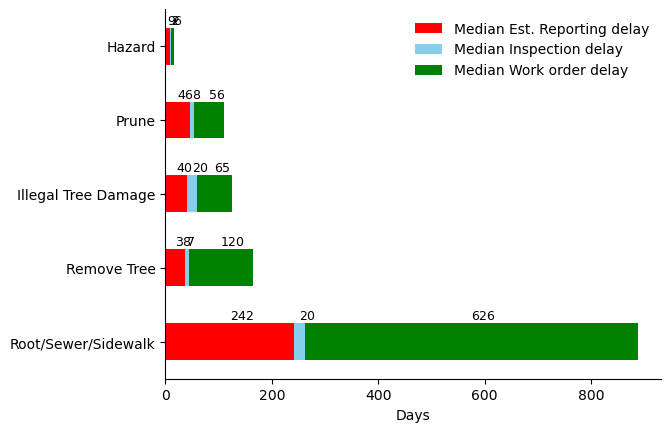

Hazard


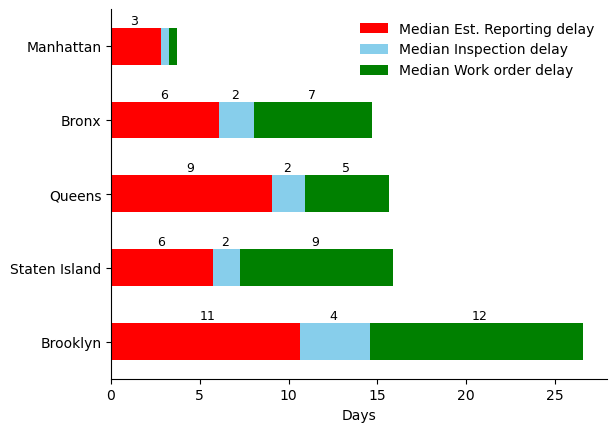

Remove Tree


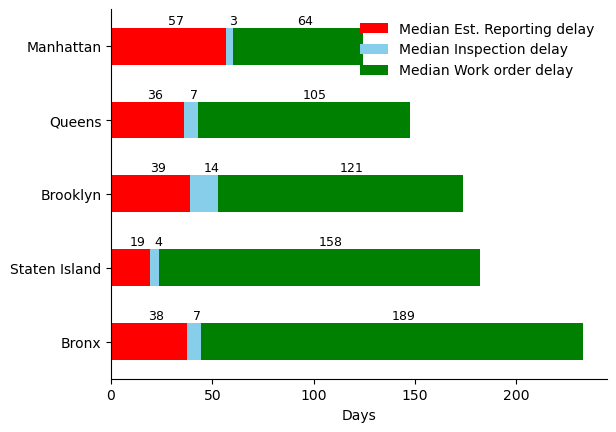

Prune


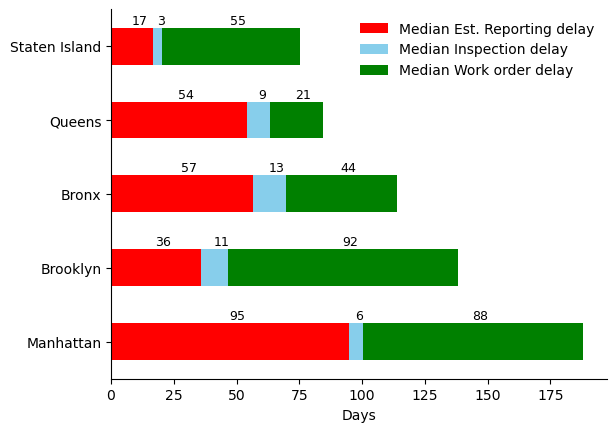

Root/Sewer/Sidewalk


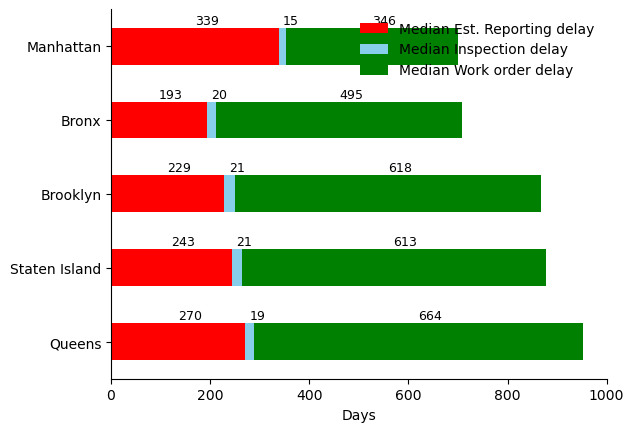

Illegal Tree Damage


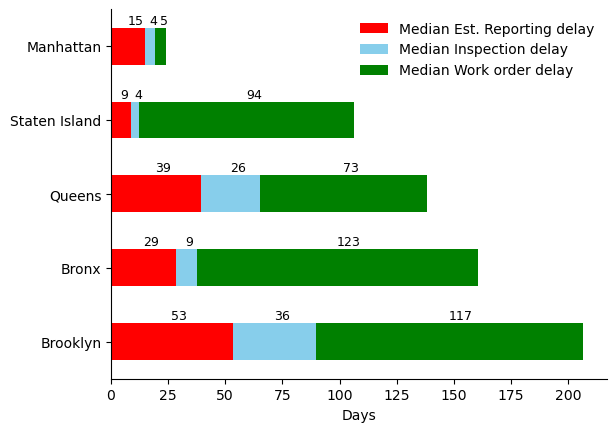

In [36]:
helpers.plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}category_notimputed_')

Overall split by typecol but not other group


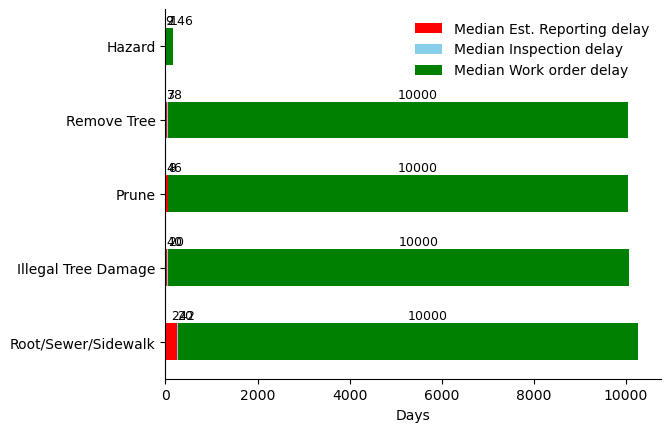

Hazard


In [37]:
helpers.plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = True, label = f'{filesavelabel}category_imputed_')